In [2]:
from keras import layers
from keras import models
from keras import optimizers
import matplotlib.pyplot as plt
import os, shutil
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from keras import optimizers

In [3]:
base_dir = 'drive/MyDrive/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [4]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))


total training cat images: 1000
total training dog images: 1000
total test cat images: 500
total test dog images: 500
total validation cat images: 500
total validation dog images: 500


## Using a Pretrained Convnet

In [5]:
from keras.applications import VGG16

In [6]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [7]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

#### a) Fast Feature Extraction WithOUT Data Augmentation

In [8]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [9]:
# features matrix size comes from last layer of conv_base i.e. block5_pool (MaxPooling2D) which has output shape of 4,4,512

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory,target_size=(150, 150),batch_size=batch_size,class_mode='binary')

    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

In [10]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


The extracted features are currently of shape (samples, 4, 4, 512). To feed them to a densely-connected classifier, first we must flatten them to (samples, 8192):

In [11]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [12]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [13]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

In [14]:
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 2s 9ms/step - loss: 0.6495 - acc: 0.6225 - val_loss: 0.4433 - val_acc: 0.8490
Epoch 2/30
100/100 [==============================] - 1s 5ms/step - loss: 0.4620 - acc: 0.7823 - val_loss: 0.3761 - val_acc: 0.8500
Epoch 3/30
100/100 [==============================] - 1s 5ms/step - loss: 0.3604 - acc: 0.8548 - val_loss: 0.3254 - val_acc: 0.8730
Epoch 4/30
100/100 [==============================] - 1s 5ms/step - loss: 0.3176 - acc: 0.8612 - val_loss: 0.3100 - val_acc: 0.8720
Epoch 5/30
100/100 [==============================] - 1s 6ms/step - loss: 0.3036 - acc: 0.8802 - val_loss: 0.2889 - val_acc: 0.8880
Epoch 6/30
100/100 [==============================] - 1s 5ms/step - loss: 0.2722 - acc: 0.8884 - val_loss: 0.2796 - val_acc: 0.8900
Epoch 7/30
100/100 [==============================] - 1s 6ms/step - loss: 0.2355 - acc: 0.9076 - val_loss: 0.2690 - val_acc: 0.8950
Epoch 8/30
100/100 [==============================] - 1s 5ms/step - loss: 0.

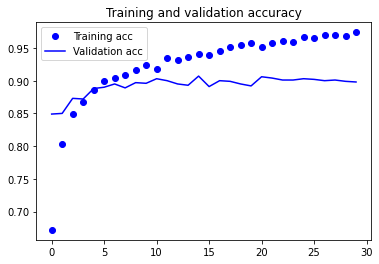

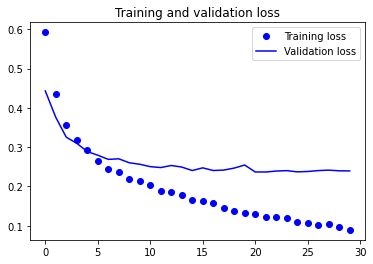

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### b) Feature Extraction with Data Augmentation (Improve Accuracy of Model)

Adding a densely connected classifier on top of the convolutional base

In [16]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


Freeze conv_base:

Note that in order for these changes to take effect, you must first compile the model. If you ever modify weight trainability after compilation, you should then recompile the model, or these changes will be ignored.

In [18]:
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [19]:
conv_base.trainable = False
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [20]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150*150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [21]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

In [22]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
100/100 [==============================] - 28s 273ms/step - loss: 0.6566 - acc: 0.6143 - val_loss: 0.4600 - val_acc: 0.8160
Epoch 2/30
100/100 [==============================] - 27s 268ms/step - loss: 0.5166 - acc: 0.7574 - val_loss: 0.3763 - val_acc: 0.8490
Epoch 3/30
100/100 [==============================] - 27s 268ms/step - loss: 0.4426 - acc: 0.8084 - val_loss: 0.3394 - val_acc: 0.8620
Epoch 4/30
100/100 [==============================] - 27s 267ms/step - loss: 0.3972 - acc: 0.8320 - val_loss: 0.3122 - val_acc: 0.8730
Epoch 5/30
100/100 [==============================] - 27s 268ms/step - loss: 0.3865 - acc: 0.8395 - val_loss: 0.3073 - val_acc: 0.8720
Epoch 6/30
100/100 [==============================] - 26s 264ms/step - loss: 0.3774 - acc: 0.8321 - val_loss: 0.2884 - val_acc: 0.8790
Epoch 7/30
100/100 [==============================] - 27s 266ms/step - loss: 0.3582 - acc: 0.8428 - val_loss: 0.2894 - val_acc: 0.8850
Epoch 8/30
100/100 [==============================] - 2

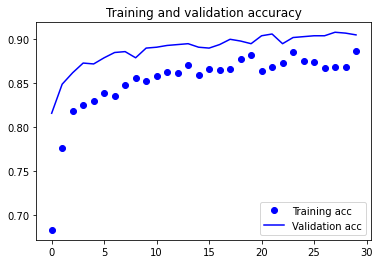

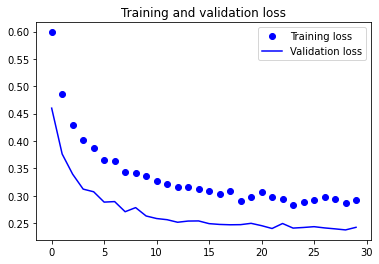

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### c) Fine Tuning

Steps for fine-tuning a network are as follows:(First 3 steps already completed above)

1 Add your custom network on top of an already-trained base network.

2 Freeze the base network.

3 Train the part you added.

4 Unfreeze some layers in the base network.

5 Jointly train both these layers and the part you added.

In [26]:
# We will Fine Tune / un-freeze the last three convolutional layers, which means all layers up to block4_pool should be frozen.
# and the layers block5_conv1, block5_conv2, and block5_conv3 should be trainable

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [29]:
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [30]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [31]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
100/100 [==============================] - 31s 295ms/step - loss: 0.3258 - acc: 0.8582 - val_loss: 0.2424 - val_acc: 0.9020
Epoch 2/100
100/100 [==============================] - 29s 292ms/step - loss: 0.2593 - acc: 0.8849 - val_loss: 0.2158 - val_acc: 0.9180
Epoch 3/100
100/100 [==============================] - 29s 292ms/step - loss: 0.2626 - acc: 0.8843 - val_loss: 0.1939 - val_acc: 0.9240
Epoch 4/100
100/100 [==============================] - 29s 291ms/step - loss: 0.2239 - acc: 0.9031 - val_loss: 0.1946 - val_acc: 0.9240
Epoch 5/100
100/100 [==============================] - 29s 286ms/step - loss: 0.2116 - acc: 0.9122 - val_loss: 0.1832 - val_acc: 0.9260
Epoch 6/100
100/100 [==============================] - 28s 281ms/step - loss: 0.1961 - acc: 0.9094 - val_loss: 0.2099 - val_acc: 0.9220
Epoch 7/100
100/100 [==============================] - 28s 282ms/step - loss: 0.1696 - acc: 0.9273 - val_loss: 0.1776 - val_acc: 0.9290
Epoch 8/100
100/100 [===========================

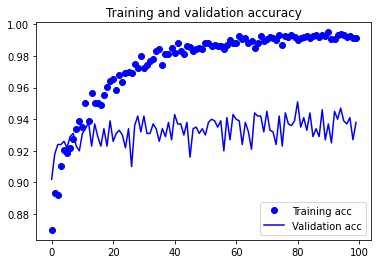

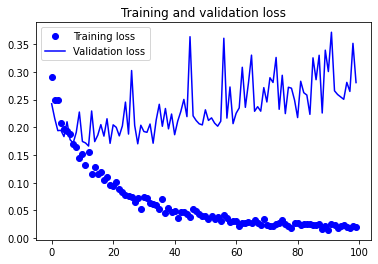

In [32]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

These curves look very noisy. To make them more readable, we can smooth them by replacing every loss and accuracy with exponential moving averages of these quantities. Here's a trivial utility function to do this:

In [33]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

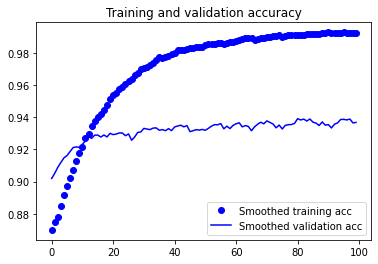

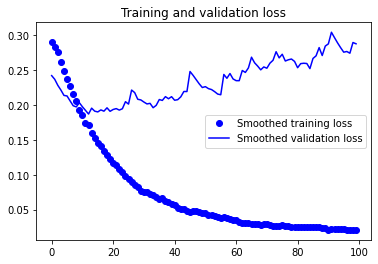

In [34]:
plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Test Model on Test Data

In [35]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(150, 150),
                                                  batch_size=20,
                                                  class_mode='binary')

Found 1000 images belonging to 2 classes.


In [38]:
test_loss, test_acc = model.evaluate(test_generator, steps=50)

50/50 [==============================] - 6s 116ms/step - loss: 0.3236 - acc: 0.9370


In [39]:
print('test acc:', test_acc)

test acc: 0.9369999766349792
